# Lecture 10: Clustering

Unsupervised learning with the goal of finding *groups* in the data.

Malcolm Gladwell pasta sauce example.

Neuroscience: cell types

Political science: voting blocks, etc.

Psychology: survey responses.


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [84]:
def fakeClusterData(rng_seed = None, k = 2, g=2, n=50, s_between=4, s_within=1):
    """
    Make fake clustered data.  arguments:
    
    Arguments (default)
    - rng_seed: random seed for consistent results (None)
    - k: number of features (2)
    - g: number of groups (2)
    - n: number of points per group (50)
    - s_between: standard deviation of group means (4)
    - s_within: standard deviation of points in group (1)
    
    Returns:
    data frame with columns called F0 ... F(k-1)
    """
    gs = [chr(i) for i in range(ord('a'), ord('a')+g)]
    fs = ['F'+str(i) for i in range(k)]
    mus = {}
    cvs = {}
    df = pd.DataFrame(columns = fs, dtype=float)
    rng = np.random.default_rng(rng_seed)
    for g in gs:
        mus[g] = rng.normal(0,s_between,k)
        cvs[g] = np.eye(k)*s_within**2
        df = df.append(pd.DataFrame(rng.multivariate_normal(mus[g], 
                                                                  cvs[g], 
                                                                  n), 
                 columns = fs))
    return df

In [87]:
df = fakeClusterData(rng_seed = 2)
df

,F0,F1
0,0.343150,-4.532461
1,2.555921,-0.946828
2,0.430791,-1.317187
3,1.037424,-2.644817
4,1.733781,-2.401550
...,...,...
45,2.170466,5.592222
46,1.809502,2.512930
47,3.050438,1.755060
48,2.107838,3.051653


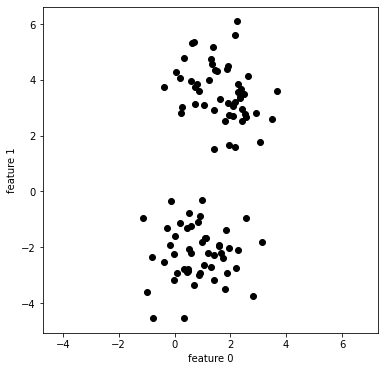

In [88]:
_ = plt.figure(figsize = (6,6))
_ = plt.scatter(df['F0'], df['F1'], color='k')
_ = plt.xlabel('feature 0')
_ = plt.ylabel('feature 1')
_ = plt.axis('equal')

# Kmeans algorithm

In [89]:
def plotClusters(df, clusters, means, make_figure = True):
    colors = {-1:'k', 0:'red', 1:'blue', 2:'green', 3:'magenta', 4:'gold', 5:'teal'}
    if clusters is None:
        clusters = -1*np.ones(len(df), dtype=int)
    if make_figure:
        _ = plt.figure(figsize = (6,6))
    _ = plt.scatter(df['F0'], df['F1'], marker = '.',
                    color=np.array([colors[x] for x in clusters]))
    for i,m in enumerate(means):
        _ = plt.scatter(m[0], m[1], marker='o', color=colors[i], s=50)
    _ = plt.xlabel('feature 0')
    _ = plt.ylabel('feature 1')
    _ = plt.axis('equal')

In [90]:
K = 2
# pick means
means = [[-4,0], [4,0]]

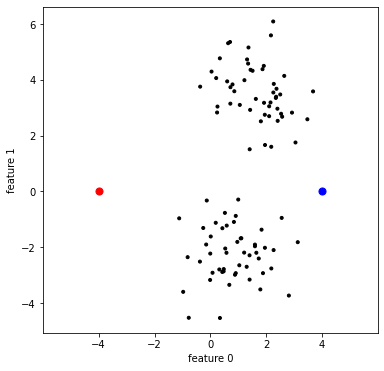

In [91]:
plotClusters(df, None, means)

In [92]:
# calculate distances
distances = np.empty((len(df),K), dtype=float)
for c in range(K):
    distances[:,c] = np.sum((df-means[c])**2, 1)

In [94]:
# assign cluster based on smallest distance for each point
cluster = np.argmin(distances,axis=1)

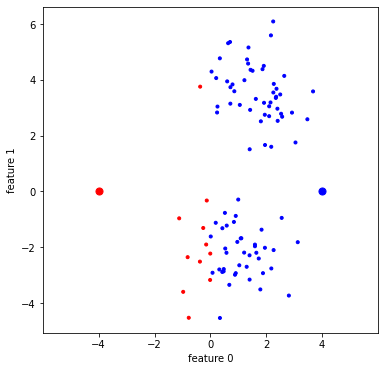

In [96]:
plotClusters(df, cluster, means)

In [97]:
# update means:
for i in range(K):
    means[i] = np.array(df[cluster==i].mean())

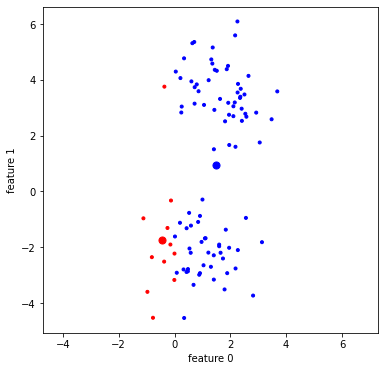

In [98]:
plotClusters(df, cluster, means)

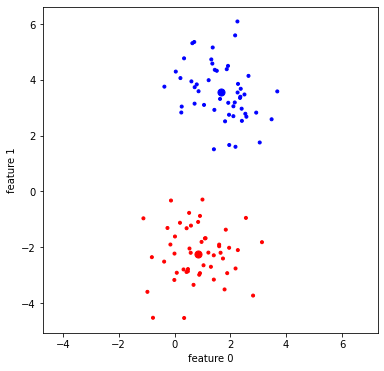

In [102]:
# calculate distances
distances = np.empty((len(df),K), dtype=float)
for c in range(K):
    distances[:,c] = np.sum((df-means[c])**2, 1)
# assign cluster based on smallest distance for each point
cluster = np.argmin(distances,axis=1)
# update means:
for i in range(K):
    means[i] = np.array(df[cluster==i].mean())
plotClusters(df, cluster, means)

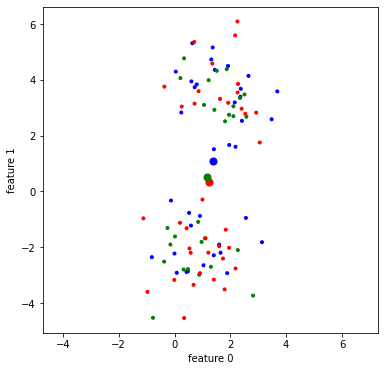

In [103]:
K = 3
# randomly pick assignments
cluster = np.random.randint(0, K, len(df))

means = [None]*K
# update means:
for i in range(K):
    means[i] = np.array(df[cluster==i].mean())
plotClusters(df, cluster, means)

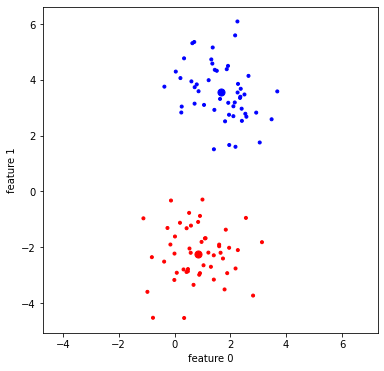

In [107]:
# calculate distances
distances = np.empty((len(df),K), dtype=float)
for c in range(K):
    distances[:,c] = np.sum((np.array(df)-means[c])**2, 1)

# assign cluster based on smallest distance for each point
cluster = np.nanargmin(distances,axis=1)

# update means:
for i in range(K):
    means[i] = np.array(df[cluster==i].mean())

plotClusters(df, cluster, means)

In [108]:
means

[array([ 0.84264493, -2.22425106]),
 array([1.67390472, 3.56059402]),
 array([nan, nan])]

### Less obvious clustering

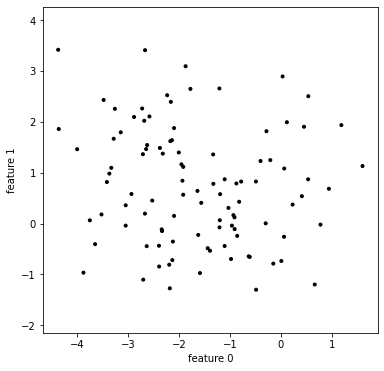

In [121]:
df = fakeClusterData(s_between = 2)
plotClusters(df, None, [])

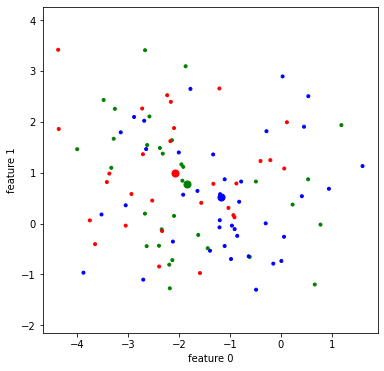

In [132]:
K = 3
# randomly pick assignments
cluster = np.random.randint(0, K, len(df))
means = [None]*K

# update means:
for i in range(K):
    means[i] = np.array(df[cluster==i].mean())
plotClusters(df, cluster, means)

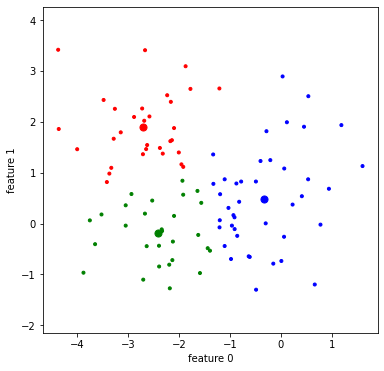

In [140]:
# calculate distances
distances = np.empty((len(df),K), dtype=float)
for c in range(K):
    distances[:,c] = np.sum((np.array(df)-means[c])**2, 1)

# assign cluster based on smallest distance for each point
cluster = np.nanargmin(distances,axis=1)

# update means:
for i in range(K):
    means[i] = np.array(df[cluster==i].mean())

plotClusters(df, cluster, means)

### full algorithm

In [141]:
def kmeans(K, X, rnd_seed = None):
    # initialize prior cluster to all zeros
    oldcluster = np.zeros(len(df), dtype=int)
    # set RNG
    rng = np.random.default_rng(rnd_seed)
    # randomly pick cluster assignment
    cluster = rng.integers(0, K, len(X))
    # initialize list of means
    means = [None]*K
    # initialize distances
    distances = np.empty((len(X),K), dtype=float)
    # if any assignments have changed, iterate again
    while any(oldcluster != cluster):
        # find means given cluster assignment
        for i in range(K):
            means[i] = np.array(X[cluster==i].mean())
        # find distances
        for c in range(K):
            distances[:,c] = np.sum((np.array(X)-means[c])**2, 1)
        # assign clusters (setting old appropriately first)
        oldcluster = cluster
        cluster = np.nanargmin(distances,axis=1)
        
    return (cluster, means)

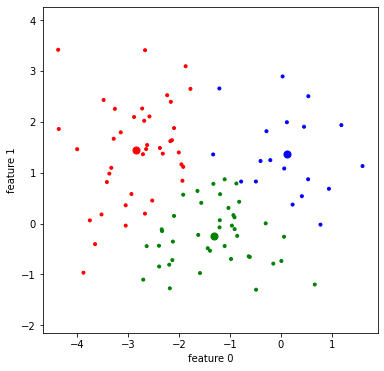

In [158]:
cluster, means = kmeans(3, df, rnd_seed = None)
plotClusters(df, cluster, means)

### kmeans is random

we should probably check consistency

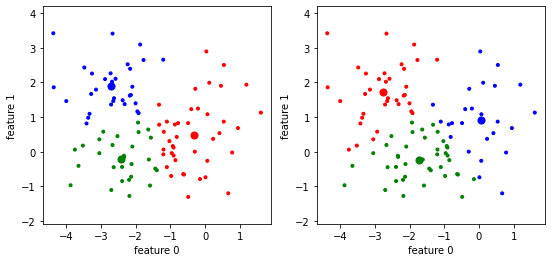

In [160]:
cluster1, means1 = kmeans(3, df)
cluster2, means2 = kmeans(3, df)

fig, axs = plt.subplots(1,2,figsize=(9,4))
plt.sca(axs[0])
plotClusters(df, cluster1, means1, make_figure = False)
plt.sca(axs[1])
plotClusters(df, cluster2, means2, make_figure = False)

### Consistency via rand score

how similar are the clusterings?   Note that the labels themselves are arbitrary.

In [168]:
c1 = np.array([1, 1, 0, 0, 2])
(c1[None,:] == c1[:,None]).astype(int)

array([[1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1]])

In [169]:
ut_id = np.triu_indices(len(cluster1), 1)
cc1 = (cluster1[None,:] == cluster1[:,None])[ut_id]
cc2 = (cluster2[None,:] == cluster2[:,None])[ut_id]

In [170]:
a = np.sum(cc1 & cc2)
b = np.sum(~cc1 & ~cc2)
c = np.sum(cc1 & ~cc2)
d = np.sum(~cc1 & cc2)

# sanity check
n = len(cluster1)
assert (a+b+c+d) == n*(n-1)//2

print(a,b,c,d)

1167 2779 496 508


In [171]:
(a+b)/(a+b+c+d)

0.7971717171717172

In [172]:
from sklearn.metrics import rand_score
rand_score(cluster1, cluster2)

0.7971717171717172

## OSRI

In [173]:
osri = pd.read_csv('osri-data.csv', sep = '\t')

In [176]:
osri

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,IP,engnat,age,education,gender,orientation,race,religion,hand,fromgoogle
0,1,1,2,3,5,5,5,4,2,4,...,ID,2,21,2,1,1,2,3,1,2
1,1,1,4,2,5,5,4,1,1,3,...,GB,1,25,4,1,1,6,1,1,2
2,1,4,1,4,1,1,1,3,1,4,...,US,1,22,2,1,3,3,1,1,2
3,3,5,5,5,5,5,5,4,4,5,...,US,1,16,2,3,2,1,7,1,2
4,2,1,4,2,4,3,5,3,5,2,...,US,1,30,3,1,2,6,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209613,2,5,5,4,1,4,2,4,2,4,...,NZ,1,17,2,3,2,1,1,1,1
209614,1,5,3,5,5,4,3,3,4,5,...,US,1,21,3,3,3,6,1,1,2
209615,1,5,1,4,2,2,3,2,1,5,...,GB,1,19,2,3,4,6,7,1,2
209616,2,5,3,4,5,5,5,2,3,5,...,US,1,14,1,2,2,1,2,1,1


In [177]:
# osri.columns
features = ['Q'+str(n) for n in range(1, 45)]

## Fitting kmeans clustering

In [178]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=2)
km.fit(osri[features])

KMeans(n_clusters=2)

In [179]:
km.cluster_centers_

array([[2.51372323, 2.92836683, 3.68522258, 2.48485631, 3.33614294,
        3.41413881, 3.88764322, 2.61544421, 3.58028503, 3.3038951 ,
        3.20294891, 1.94428531, 3.30189942, 2.62832222, 3.67904771,
        2.09630917, 3.23606546, 3.12646741, 3.54354104, 2.74997652,
        3.40679001, 2.87793482, 4.27508687, 2.81873356, 2.51557804,
        2.21453559, 3.27168248, 2.08279724, 3.18496431, 2.1412824 ,
        3.71744694, 2.22760143, 3.36607814, 2.18942524, 3.72764838,
        2.0196868 , 4.26845417, 2.02364294, 3.44699709, 2.16922192,
        3.89046065, 2.00167872, 3.26034232, 2.11835556],
       [1.62533552, 4.45682048, 2.52269476, 3.65335841, 2.65637205,
        3.94247553, 3.03333494, 3.61564363, 2.21858174, 3.85020171,
        2.58422939, 3.26563479, 2.22743784, 3.85986949, 2.93967083,
        3.42719835, 2.16612019, 3.66264847, 2.42325249, 4.24441873,
        2.59195236, 3.9417844 , 3.91514377, 3.75127377, 1.63688381,
        3.43327386, 2.34711574, 3.25788772, 2.19176431, 3.4

In [180]:
km.labels_

array([1, 0, 1, ..., 1, 1, 0], dtype=int32)

## Evaluating clustering

### ability to match some known labels

In [182]:
osri['cluster'] = km.labels_
# gender	1=Male, 2=Female, 3=Other
osri['gender_str'] = osri['gender'].map({0:'unknown',1:'male', 2:'female',3:'other'})

In [183]:
osri.groupby(['gender_str','cluster']).agg(n = ('cluster',len)).unstack('gender_str')

n                      
gender_str female   male  other unknown
cluster                                
0           15171  64731   4356     958
1           82620  26937  13003    1842

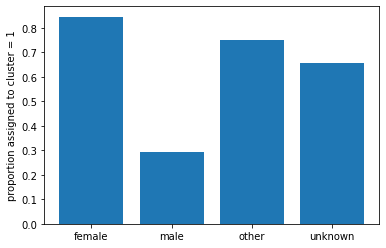

In [184]:
clust_gender = osri.groupby('gender_str').agg(p_c1 = ('cluster', 'mean')).reset_index()
_ = plt.bar(clust_gender['gender_str'], clust_gender['p_c1'])
_ = plt.ylabel('proportion assigned to cluster = 1')


#### Rand index

Given some known, true grouping structure compare whether things were clustered together the same way:  
for each *pair* of data points, ask if the two data points are in the same cluster or not, in the true clusters, and in the learned clusters.

In [187]:
from sklearn.metrics import rand_score
rand_score(osri['gender'], osri['cluster'])

0.6202888161983383

### Based on cluster separation

e.g., how similar are items in the same cluster, compared to how similar are items in different clusters.

- can use within/across cluster dispersion (Calinki-Harabasz)   
- can use within/across cluster pairwise distances (Silhouette)  
- or some mix, like distances of points in cluster to cluster center, compared to distances between cluster centers.

### Silhouette

distance between points in same cluster, compared to distance to points in closest other cluster.

-1 to +1.  0 is not separated, +1 is amazingly perfect

In [189]:
from sklearn.metrics import silhouette_score
# silhouette_score(osri[features], osri['cluster'])
# O(n^2) !  
subset = osri.sample(1000)
silhouette_score(subset[features], subset['cluster'])

0.11908950621639142

### Davies-Bouldi

zero is best, higher is worse.  scale depends on data.

In [190]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(osri[features], osri['cluster'])


2.6158955064640796

### Variance ratio: Calinski-Harabasz

ratio of between cluster variance (variance of cluster means) to within cluster variance (variance of distances from cluster).  

Higher is better, but numbers depend on data scale.

In [192]:
from sklearn.metrics import calinski_harabasz_score
calinski_harabasz_score(osri[features], osri['cluster'])

28959.757535289504

In [ ]:
calinski_harabasz_score(osri[features], np.random.randint(0,2,len(osri)))

## How to pick number of clusters?

best variance ratio a la Calinski Harabasz

In [194]:
subset = osri.sample(1000)

In [196]:
Ks = list(range(2, 10))
rand_gender = []
rand_consistency = []
silhouette = []
variance_ratio = []

for K in Ks:
    km = KMeans(n_clusters=K).fit(subset[features])
    # rand index to some ground truth label
    rand_gender.append(rand_score(km.labels_, subset['gender']))
    # rand index to another kmeans output
    
    rand_consistency.append(rand_score(km.labels_, 
                                 (KMeans(n_clusters=K)
                                  .fit(subset[features])
                                  .labels_)))
    # silhoutte coefficient
    silhouette.append(silhouette_score(subset[features], km.labels_))
    # variance ratio
    variance_ratio.append(calinski_harabasz_score(subset[features], km.labels_))

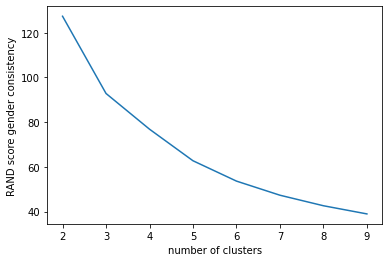

In [218]:
_ = plt.plot(Ks, variance_ratio)
_ = plt.xlabel('number of clusters')
_ = plt.ylabel('Variance ratio')

In [213]:
K = 100
rand_score(np.random.randint(0,K,1000), 
           np.random.randint(0,K,1000))

0.9804944944944944

# Clustering

**goal**: find discrete groups, or clusters, of data points

![clustering](sklearn_clustering.png)


In [221]:
means

[array([-2.83812255,  1.44048037]),
 array([0.11794463, 1.35983792]),
 array([-1.30450599, -0.23785666])]

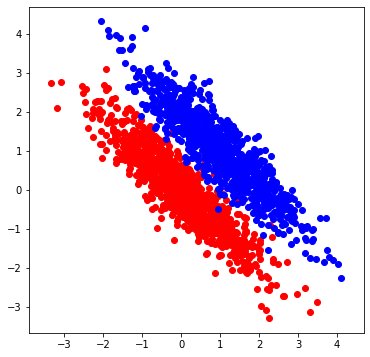

In [233]:
X1 = np.random.multivariate_normal([0,0], [[1, -0.9], [-0.9, 1]], 1000)
X2 = np.random.multivariate_normal([1,1], [[1, -0.9], [-0.9, 1]], 1000)

_ = plt.figure(figsize = (6,6))
_ = plt.scatter(X1[:,0], X1[:,1], color = 'r')
_ = plt.scatter(X2[:,0], X2[:,1], color = 'b')
_ = plt.axis('equal')